In [64]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib

from fklearn.causal.validation.curves import relative_cumulative_gain_curve  # norm cumulative effect gain curve
from fklearn.causal.validation.auc import area_under_the_relative_cumulative_gain_curve


from cycler import cycler

color=['0.0', '0.4', '0.8']
default_cycler = (cycler(color=color))
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)
pd.set_option('display.max_columns', 8)

#### Metalearners for Discrete Treatments

Treatment effect heterogeneity refers to identifying how units respond differently to treatment ie you want to estimate:

$\tau _i (x) = E[Y_i(1) - Y_i(0)|X]=E[\tau _i | X]$ or $E[\delta Y_i(t)|X]$ in the continuous case.

You want to know how sensitive the units are to treatment. This is useful where you need to do some prioritization of treatment because you can't treat everyone due to limited resources or when the treatment effect is positive for some units but negative for others. Regression with interaction terms can be used to get conditional average treatment effect (CATE) estimates. When the treatment response function is nonlinear, like in the case of a binary outcome or in the case where the outcome is marginally decreasing, a predictive model might yield a good ordering of the CATE.

Metalearners are an effortless way to leverage machine learning algorithms for approximating treatment effects. They can be used to estimate the ATE, but in general, they are mostly used for CATE estimation, since they can deal pretty well with high-dimensional data. Metalearners recycle predictive models for causal inference. All predictive models can be repurposed for causal inference.

The dataset is of a marketing team at an online retailer. The goal is to figure out which customers are receptive to a marketing email. These emails have the potential of making customers spend more, but some customers don't like to receive them. The aim is to estimate the conditional average treatment effect of the email on customer's future purchase volumne, that way, the team can use this estimate to decide who to send it to. There is historical data where emails have been sent to customers. There are also a few data points from an experiment where the marketing email was randomized, which can be used to evaluate the model since there is so little of it.

In [65]:
data_biased = pd.read_csv('data/email_obs_data.csv')        # observational data
data_rnd = pd.read_csv('data/email_rnd_data.csv')           # randomized data
print(data_biased.shape, data_rnd.shape)
data_rnd.head()

(300000, 27) (10000, 27)


,mkt_email,next_mnth_pv,age,tenure,...,jewel,books,music_books_movies,health
0,0,244.26,61.0,1.0,...,1,0,0,2
1,0,29.67,36.0,1.0,...,1,0,2,2
2,0,11.73,64.0,0.0,...,0,1,0,1
3,0,41.41,74.0,0.0,...,0,4,1,0
4,0,447.89,59.0,0.0,...,1,1,2,1


In [66]:
data_biased.columns 

Index(['mkt_email', 'next_mnth_pv', 'age', 'tenure', 'ammount_spent',
       'vehicle', 'food', 'beverage', 'art', 'baby', 'personal_care', 'toys',
       'clothing', 'decor', 'cell_phones', 'construction', 'home_appliances',
       'electronics', 'sports', 'tools', 'games', 'industry', 'pc', 'jewel',
       'books', 'music_books_movies', 'health'],
      dtype='object')

In [67]:
y = "next_mnth_pv"          # mkt_email is the treatment column (binary)
T = "mkt_email"             # next_mnth_pv is the outcome (purchase volume) column
X = list(data_rnd.drop(columns=[y,T]).columns) # covariates

train, test = data_biased, data_rnd

#### T-learner

If you have a categorical treatment, a T-learner fits one outcome model $\mu_t(x)$ for every treatment in order to estimate the potential outcome $Y_t$. In the case of a binary treatment, there are only two models that you need to estimate (so T is for Two). Once you have those models, you can make counterfactual predictions for each treatment and get the CATE.

$\mu  _0 (x) = E[Y|T=0, X]$                          --- outcome model for control conditioned on covariates

$\mu  _1 (x) = E[Y|T=1, X]$                          --- outcome model for treated conditioned on covariates

$\hat \tau (x) _ i = \hat \mu _1 (X_i) - \hat \mu _0 (X_i)$     --- CATE using counterfactuals

In [68]:
from lightgbm import LGBMRegressor 

np.random.seed(123)

m0 = LGBMRegressor()        # outcome model for control
m1 = LGBMRegressor()        # outcome model for treated

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])    # fit control outcome model to training data
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])    # fit control outcome model to training data

LGBMRegressor()

In [69]:
# make counterfactual predictions
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X])) # assign predicted cate

Text(0.5, 1.0, 'T-learner')

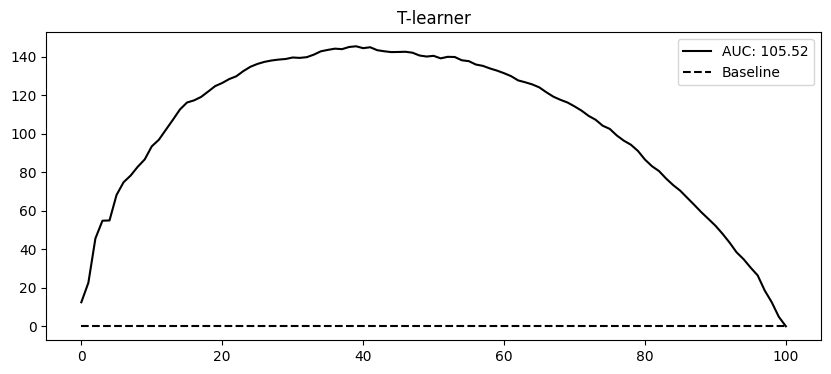

In [70]:
# evaluate with cumulative gain curve and area under the curve
gain_curve_test = relative_cumulative_gain_curve(t_learner_cate_test, T, y, prediction="cate") # normalized
auc = area_under_the_relative_cumulative_gain_curve(t_learner_cate_test, T, y, prediction="cate") # normalized

plt.figure(figsize=(10,4))
plt.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
plt.hlines(0,0,100, linestyle="--", color="black", label="Baseline")

plt.legend()
plt.title("T-learner")


T-learner is a reasonable first choice due to its simplicity, but it has a potential issue that might manifest depending on the situation. T-learner works best in situations where you have a lot of data for all treatment levels otherwise in a small dataset, it is prone to regularization bias. Imagine a situation where you have lots of data for untreated and very little data for the treated often due to treatment being expensive. Suppose the outcome is non linear but the treatment effect is constant. When we build the models, due to the paucity of treated data, there is a chance the $\hat \mu _1$ model will be simple, to avoid overfitting. In contrast, $\hat \mu _0$ will be complex to capture the nonlinearity in the outcome, because of the abundance of untreated data. This difference between $\hat \mu _0$ and $\hat \mu _1$ can happen even if you have the same hyperparameters for both models. Self-regularization makes a lot of sense from a machine learning standpoint; if you have little data, use simpler models. If we compute the CATE, the nonlinearity in $\hat \mu _1(X)- \hat \mu_ 0(X)$ will lead to a nonlinear CATE instead of a constant effect. What happens is that the model for the untreated can pick up the nonlinearity but the model for the treated cannot, because it is regularized to deal with a small sample size. If you choose to use less regularization on the treated model, you run the risk of overfitting, ie a catch 22.

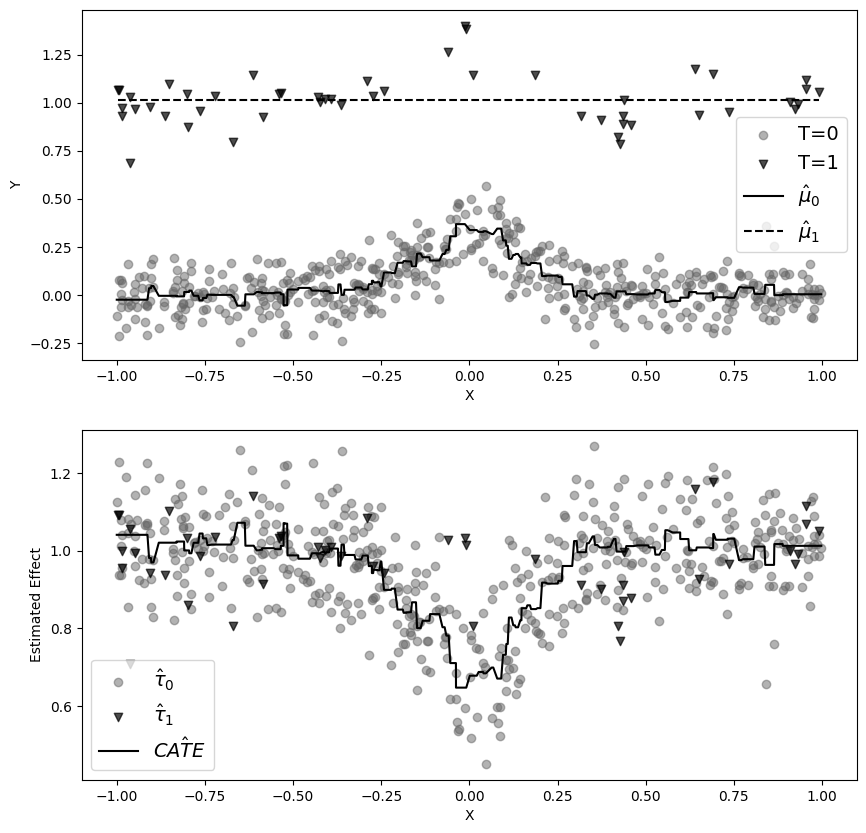

In [71]:
np.random.seed(123)

def g_kernel(x, c=0, s=0.05):
    return np.exp((-(x-c)**2)/s)

n0 = 500                                                # control group size
x0 = np.random.uniform(-1, 1, n0)
y0 = np.random.normal(0.3*g_kernel(x0), 0.1, n0)

n1 = 50                                                 # treated group size
x1 = np.random.uniform(-1, 1, n1)
y1 = np.random.normal(0.3*g_kernel(x1), 0.1, n1) + 1    # add treatment effect of 1

df = pd.concat([pd.DataFrame(dict(x=x0, y=y0, t=0)), pd.DataFrame(dict(x=x1, y=y1, t=1))]).sort_values(by="x")

m0 = LGBMRegressor(min_child_samples=25)
m1 = LGBMRegressor(min_child_samples=25)

m0.fit(x0.reshape(-1,1), y0)    # reshape feature set to 2D as expected by machine learning model frameworks
m1.fit(x1.reshape(-1,1), y1)    # reshape feature set to 2D as expected by machine learning model frameworks

m0_hat = m0.predict(df.query("t==0")[["x"]])    # df[["x"]] yields 2D DataFrame no need to reshape to predict 
m1_hat = m1.predict(df.query("t==1")[["x"]])    # df["x"] yields 2D Series so need to reshape(-1,1) to predict  

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

ax1.scatter(x0, y0, alpha=0.5, label="T=0", marker=marker[0], color=color[1])
ax1.scatter(x1, y1, alpha=0.7, label="T=1", marker=marker[1], color=color[0])

# modeled potential outcomes
ax1.plot(df.query("t==0")[["x"]], m0_hat, color="black", linestyle="solid", label="$\hat \mu _0$") # control
ax1.plot(df.query("t==1")[["x"]], m1_hat, color="black", linestyle="--", label="$\hat \mu _1$" ) # treated

ax1.set_ylabel("Y")
ax1.set_xlabel("X")
ax1.legend(fontsize=14)

# approximate treatment effect by imputing one potential outcome (also used in X-learner)
tau_0 = m1.predict(df.query("t==0")[["x"]]) - df.query("t==0")["y"]  # use one conterfactual
tau_1 = df.query("t==1")["y"] - m0.predict(df.query("t==1")[["x"]])

ax2.scatter(df.query("t==0")[["x"]],tau_0, label="$\hat \\tau_0$",alpha=0.5,marker=marker[0],color=color[1])
ax2.scatter(df.query("t==1")[["x"]],tau_1, label="$\hat \\tau_1$",alpha=0.7,marker=marker[1],color=color[0])

# model treatment effect by imputing both potential outcomes (T-learner)
ax2.plot(df[["x"]], m1.predict(df[["x"]]) - m0.predict(df[["x"]]), label="$\hat{CATE}$", color="black")

ax2.set_ylabel("Estimated Effect")
ax2.set_xlabel("X")
ax2.legend(fontsize=14)

#### X-Learner

X-learner has two stages and a propensity score model. First, you split the samples into treated and untreated and fit a model for each group:

$\hat \mu_0 \approx E[Y|T=0,X]$

$\hat \mu_1 \approx E[Y|T=1,X]$

Second, you'll impute the missing potential outcomes, using the fitted models and the observed outcome for each treatment group:

$\hat \tau (X, T=0) = \hat \mu_1(X,T=0) - Y_{T=0}$

$\hat \tau (X, T=1) =  Y_{T=1} - \hat \mu_0(X,T=1)$

Then, you fit two more models to predict those estimated effects. The idea is that this second stage models will approximate the CATE (not the treatment effects) on the control and treated populations.

$\hat \mu (X) _ {\tau 0} \approx E[ \tau (X) | T = 0]$

$\hat \mu (X) _ {\tau 1} \approx E[ \tau (X) | T = 1]$

Notice that even though you have more control data, $\hat \tau (X, T=0)$ is wrong, because it was constructed using $\widehat \mu _1$ which was fitted in a very small sample. Because $\hat \tau (X, T=0)$ is wrong, $\hat \mu (X) _ {tau 0}$ will also be misleading. In contrast, $\hat \mu (X) _ {\tau 1}$ will be probably be correct since $\hat \tau (X, T=1)$ is also correct, as it was generated using $\widehat \mu _1$ model. That is, you have one model that is wrong because you've imputed the treatment effects incorrectly due to scarcity of data points, and another model that is correct because you've correctly imputed those values. How are these models combined in a way that gives more weight to the correct model?. You can use a propensity score model :

$\widehat {\tau(x)} = \hat \mu (X) _ {\tau 0} \hat e(x) + \hat \mu (X) _ {\tau 1}(1-\hat e(x))$

Since there are very few treated units, $\hat e(x)$ is very small, which gives a very small weight to the wrong CATE model, $\hat \mu (X) _ {\tau 0}$. In contrast, $1-\hat e(x)$ is close to 1, so you will give more weight to the correct CATE model $\hat \mu (X) _ {\tau 1}$. More generally, this weighted average using the propensity score will favor the treatment effect estimates that were obtained from the $\widehat \mu _t$ model that was trained using more data. 

Compared to T-learner, X-learner does a better job in correcting the wrong CATE estimated at the nonlinearity. In general, the X-learner performs better when a treatment group is much larger than the other.
Another option is the domain adaptation learner. It is the X-learner, but using the propensity score model to estimate $\hat \mu _t (X)$ (potential outcome model) with weights set to $1/\hat P(T=t)$.

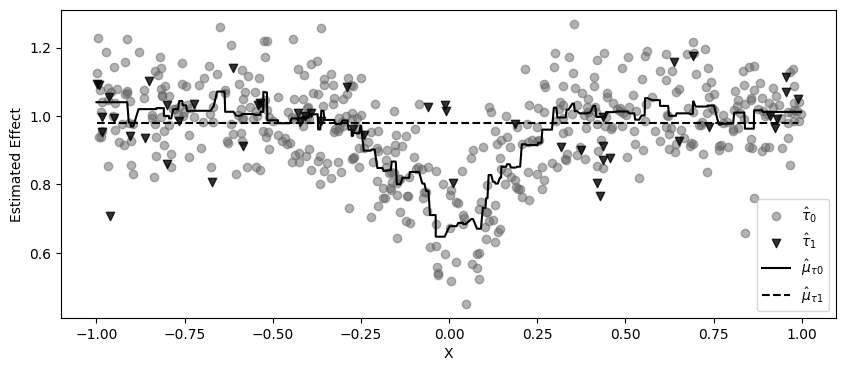

In [72]:
from sklearn.linear_model import LogisticRegression 

np.random.seed(1)

mu_tau0 = LGBMRegressor(min_child_samples=25)   # model for predicting tau_0 from X ie the CATE
mu_tau1 = LGBMRegressor(min_child_samples=25)   # model for predicting tau_1 from X ie the CATE

# predicting treatment effects from one imputation (above)
mu_tau0.fit(df.query("t==0")[["x"]], tau_0)     # tau_0 produced by imputing m1 for T=0; predict CATE
mu_tau1.fit(df.query("t==1")[["x"]], tau_1)     # tau_1 produced by imputing m0 for T=1; predict CATE

mu_tau0_hat = mu_tau0.predict(df.query("t==0")[["x"]])      # CATE predictions on control
mu_tau1_hat = mu_tau1.predict(df.query("t==1")[["x"]])      # CATE predictions on treated

plt.figure(figsize=(10,4))
plt.scatter(df.query("t==0")[["x"]], tau_0, label="$\hat \\tau_0$", alpha=0.5, marker=marker[0], color=color[1])
plt.scatter(df.query("t==1")[["x"]], tau_1, label="$\hat \\tau_1$", alpha=0.8, marker=marker[1], color=color[0])

plt.plot(df.query("t==0")[["x"]], mu_tau0_hat, color="black", linestyle="solid", label="$\hat \mu_{\\tau 0}$")
plt.plot(df.query("t==1")[["x"]], mu_tau1_hat, color="black", linestyle="dashed", label="$\hat \mu_{\\tau 1}$")

plt.ylabel("Estimated Effect")
plt.xlabel("X")
plt.legend()

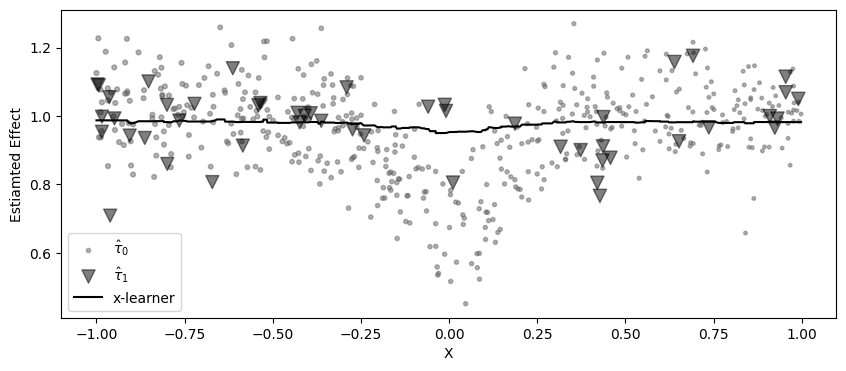

In [73]:
plt.figure(figsize=(10,4))

ps_model = LogisticRegression(penalty=None)     # propensity score model
ps_model.fit(df[["x"]], df["t"])                # P(T|X)

ps = ps_model.predict_proba(df[["x"]])[:,1]     # predict P(T==1|X)

cate = ((1-ps)*mu_tau1.predict(df[["x"]]) +     # combine cate models using propensity scores
        ps*mu_tau0.predict(df[["x"]]))          # cate is the expectation (weighted average)    

plt.scatter(df.query("t==0")[["x"]], tau_0, label="$\hat \\tau _0$", alpha=0.5, 
            s=100*(ps[df["t"]==0]), marker=marker[0], color=color[1])   # effect by imputing treated potential
plt.scatter(df.query("t==1")[["x"]], tau_1, label="$\hat \\tau_1$", alpha=0.5, 
            s=100*(1-ps[df["t"]==1]), marker=marker[1], color=color[0]) # effect by imputing control potential

plt.plot(df[["x"]], cate, label="x-learner", color="black")
plt.ylabel("Estiamted Effect")
plt.xlabel("X")
plt.legend()

In [74]:
# Domain Adaptation
from sklearn.linear_model import LogisticRegression 
from lightgbm import LGBMRegressor 

# propensity score model
ps_model = LogisticRegression(penalty=None)     # no regularization
ps_model.fit(train[X], train[T])                # P(T=t|X), propensity score model

# first stage models
train_t0 = train.query(f"{T}==0")               # control group
train_t1 = train.query(f"{T}==1")               # treated group

m0 = LGBMRegressor()                            # control potential outcome model   
m1 = LGBMRegressor()                            # treated potential outcome model

np.random.seed(123)

m0.fit(train_t0[X], train_t0[y],                # potential outcome model for control
       sample_weight=1/ps_model.predict_proba(train_t0[X])[:,0])    # inverse probability weighting
m1.fit(train_t1[X], train_t1[y],                # potential outcome model for treated
       sample_weight=1/ps_model.predict_proba(train_t1[X])[:,1])    # inverse probability weighting  

# second stage
tau_hat_0 = m1.predict(train_t0[X]) - train_t0[y]       # treatment effect by treated outcome imputation 
tau_hat_1 = train_t1[y] - m0.predict(train_t1[X])       # treatment effect by control outcome imputation 

m_tau_0 = LGBMRegressor()                               # CATE model (from treated outcome imputation)
m_tau_1 = LGBMRegressor()                               # CATE model (from control outcome imputation)

np.random.seed(123)

m_tau_0.fit(train_t0[X], tau_hat_0)       # fit CATE model (treatment effect |X=x) from treated imputation
m_tau_1.fit(train_t1[X], tau_hat_1)


# estimate the CATE
ps_test = ps_model.predict_proba(test[X])[:,1]          # propensity scores for test data

x_cate_test = test.assign(
    cate=(ps_test*m_tau_0.predict(test[X]) +            # cate from treated imputation * treated propensity     
          (1-ps_test)*m_tau_1.predict(test[X]))         # cate from control imputation * (1-propensity)
)

Text(0.5, 1.0, 'X-Learner')

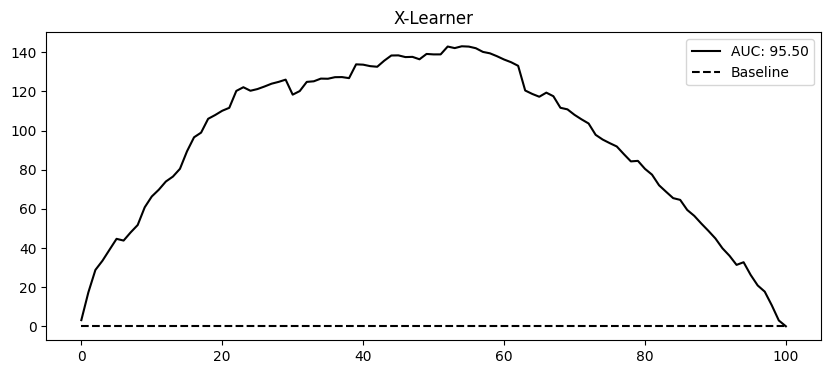

In [75]:
gain_curve_test = relative_cumulative_gain_curve(x_cate_test, T, y, prediction="cate")      # for plotting
auc = area_under_the_relative_cumulative_gain_curve(x_cate_test, T, y, prediction="cate")   # for comparison

plt.figure(figsize=(10,4))
plt.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
plt.hlines(0,0,100, linestyle='--', color="black", label="Baseline")
plt.legend()
plt.title("X-Learner")

In [76]:
# equal split of control and treated in test data
test.query(f"{T}==1").shape[0]/ test.shape[0] 

0.4952

#### Metalearners for Continuous Treatments

For continuous treatment, we are using data from chain of restaurants, where for three years, the chain randomized disocounts on six of its locations. The chain wants to now know which are the best days to give more discounts. Thus you need to understand on which days customers are more sensitive to discount (more sensitive to prices). For this problem, we need to estimate the CATE, so that the company can use the CATE predictions on a discount policy- the higher the predicted CATE, the more customers are sensitive to discounts, so the higher disocunts should be.


In [77]:
data_cont = pd.read_csv('data/discount_data.csv')
data_cont.head()

,rest_id,day,month,weekday,...,is_nov,competitors_price,discounts,sales
0,0,2016-01-01,1,4,...,False,2.88,0,79.0
1,0,2016-01-02,1,5,...,False,2.64,0,57.0
2,0,2016-01-03,1,6,...,False,2.08,5,294.0
3,0,2016-01-04,1,0,...,False,3.37,15,676.5
4,0,2016-01-05,1,1,...,False,3.79,0,66.0


In [78]:
train = data_cont.query("day<'2018-01-01'")
test = data_cont.query("day>='2018-01-01'")

#### S-Learner

The S-learner uses a single (hence S) machine learning model $\hat \mu _s$ to estimate:

$\mu (x)$ = E[Y|T,X]

To do this, you will include the treatment as a feature in the model that tries to predict the outcome Y. This model does not output a treatment effect directly; it outputs counterfactual predictions. That is, it can make predictions under different treatment regimes. If the treatment were binary, this model would still work and the difference in predictions between the test and control will be the CATE estimate:

$\hat \tau (x)_i = M_s(X_i, T=1) - M_s(X_i, T=0)$

In the continuous case, you need to define a grid of treatments. For example if discounts go from 0% to 40%, you can try [0, 10, 20, 30, 40] grid. Next, you need to expand the data you want to make predictions on so that each line gets one copy for each treatment value in the grid eg using a cartesian product (cross-join) using a constant key with a dataframe of grid values. Finally, use the fitted S-learner to make counterfactual predictions in this expanded data.

In [79]:
X = ["month", "weekday", "is_holiday", "competitors_price"]   # features 
T = "discounts"
y = "sales"

np.random.seed(123)
s_learner = LGBMRegressor()
s_learner.fit(train[X+[T]], train[y])  # S-learner includes the treatment and covariates to predict outcome

LGBMRegressor()

In [127]:
print(test.discounts.unique())  # randomized discounts range from 0 - 40 at 5% increments 
print(test.shape)

[ 5 10 20  0 30 25 15 40 35]
(2562, 11)


In [88]:
t_grid = pd.DataFrame(dict(key=1, discounts=np.array([0,10, 20, 30, 40]))) # treatments to test and merge column
test_cf = (test
           .drop(columns=["discounts"])         # drop treatment column to use discounts from t_grid after merge
           .assign(key=1)                       # add common key column as intersection for cartesian product
           .merge(t_grid)                       # cross-join (cartesian product) by inner join on key column
           # make predictions after expansion
           .assign(sales_hat = lambda d:        # counterfactuals predictions (at counterfactual discounts)
                   s_learner.predict(d[X+[T]])) # slice out features and treatment columns (conveniently last)
           )
test_cf.head(8)  # probably should have dropped outcome column, sales, too

,rest_id,day,month,weekday,...,sales,key,discounts,sales_hat
0,0,2018-01-01,1,0,...,251.5,1,0,67.957972
1,0,2018-01-01,1,0,...,251.5,1,10,444.245941
2,0,2018-01-01,1,0,...,251.5,1,20,793.045769
3,0,2018-01-01,1,0,...,251.5,1,30,1279.640793
4,0,2018-01-01,1,0,...,251.5,1,40,1512.630767
5,0,2018-01-02,1,1,...,541.0,1,0,65.672080
6,0,2018-01-02,1,1,...,541.0,1,10,495.669220
7,0,2018-01-02,1,1,...,541.0,1,20,1015.401471


In [130]:
print(test_cf.discounts.unique())       # the counterfactual discounts that were tested
print(test_cf.shape)                    # the shape of the test data with conterfactual discounts
print(test.shape[0]*5)                  # there are 5 tested discounts so df size is 5 times original test data

[ 0 10 20 30 40]
(12810, 13)
12810


/var/folders/35/13t91srs6wg9ml5d___c_nh40000gn/T/ipykernel_4436/1680750003.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=test_cf.query("day.isin(@days)")


<Axes: xlabel='discounts', ylabel='sales_hat'>

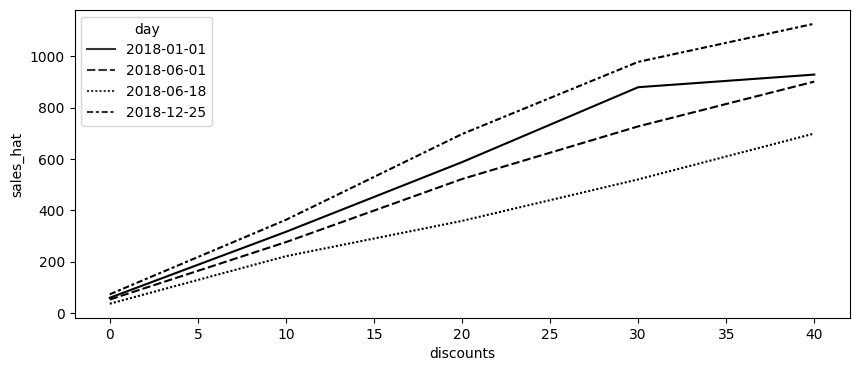

In [97]:
# Plotting predictions for a handful of units (days) for one restaurant
days = ["2018-12-25", "2018-01-01", "2018-06-01", "2018-06-18"]

plt.figure(figsize=(10,4))
sns.lineplot(data=test_cf.query("day.isin(@days)")      # variables in .query() referenced by prefixing with @ 
                    .query("rest_id==2"),               # certain days for restaurant with id 2
             palette="gray",
             y="sales_hat",                             # counterfactual predictions
             x="discounts",                             # test discounts
             style="day"                                # for each day
             )

Above, we have used a S-learner to estimate a version of the treatment response function $Y(t)$ for each unit (days). We also plotted this curve for a handful of units (days, in this case, not customers) to see what they look like. The estimated response function for 2018-12-25- that is, Christmas- is steeper than the one for a day like 2018-06-18. This means the model learned that customers are more sensitive to discounts on Christmas, compared to that particular day in June.

Whether these counterfactual predictions are correct, is another issue. To evaluate this model, we first need to have CATE prediction, meaning we have to somehow summarize the unit level curves into a single number that represents the treatment effect. One way to do that is by running a regression for each unit and extracting the slope parameter on the treatment as the CATE estimate. Since all we want is the slope parameter, we can do this efficiently, using the formula for the slope of a single variable linear regression:

$\beta = Cov(t,y)/Var(t)$

So basically in the example below, we have the restaurant, day combination as a variable. We add a grid of discounts for each restaurant,day combination. We use our counterfactual prediction model to predict sales values (outcome) for the different values (grid) of discounts (treatment). Then for each restaurant,day combination, we run a linear regression of predicting sales from the discount and store the slope parameter as the cate. Instead of running a full on linear regression, we estimate the slope parameter from covariance, variance values. The result is the treatment effect for that specific restaurant, day combination.

In [136]:
# treatment effect approximation as the coefficient of linear regression
from toolz import curry 

@curry
def linear_effect(df, y, t): # apply() supplies each row as a one-row dataframe
    return np.cov(df[y], df[t])[0,1]/df[t].var() # covariance from covariance matrix at [0,1] or [1,0]

In [137]:
# determine cate values for augmented test dataframe
cate = (test_cf
        .groupby(["rest_id", "day"])        # condition on restaurant-day, 5 rows each for discounts 0:10:40
        .apply(linear_effect(t="discounts", y="sales_hat")) # coefficient of rest_id,day single variable
        .rename("cate"))

In [131]:
cate.shape

(2562,)

In [120]:
# join cate values on original test data  (not the augmented)
test_s_learner_pred = test.set_index(["rest_id", "day"]).join(cate) # join on (rest_id, day) index
test_s_learner_pred.head()

month  weekday  weekend  is_holiday  ...   
rest_id day                                              ...   
0       2018-01-01      1        0    False        True  ...  \
        2018-01-02      1        1    False       False  ...   
        2018-01-03      1        2    False       False  ...   
        2018-01-04      1        3    False       False  ...   
        2018-01-05      1        4    False       False  ...   

                    competitors_price  discounts  sales       cate  
rest_id day                                                         
0       2018-01-01               4.92          5  251.5  37.247404  
        2018-01-02               3.06         10  541.0  40.269854  
        2018-01-03               4.61         10  431.0  37.412988  
        2018-01-04               4.84         20  760.0  38.436815  
        2018-01-05               6.29          0   78.0  31.428603  

[5 rows x 10 columns]

Text(0.5, 1.0, 'S-Learner')

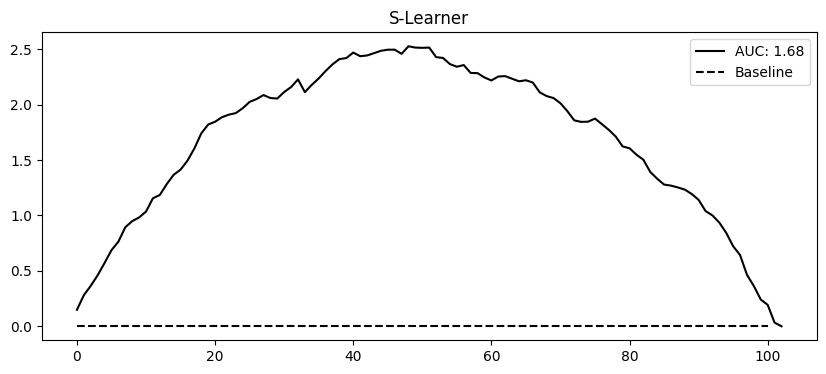

In [123]:
gain_curve_test = relative_cumulative_gain_curve(test_s_learner_pred, T, y, prediction="cate")
auc = area_under_the_relative_cumulative_gain_curve(test_s_learner_pred, T, y, prediction='cate')

plt.figure(figsize=(10,4))
plt.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
plt.hlines(0,0,100, linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner")

In the dataset above, we had lots of random data, which was used to train the (counterfactual) learner. In practice, the S-learner performs OK, even if it doesnt have random data to train. It also supports both binary and continuous treatment. The S-learner is also simple and a good first bet for any causal problem.

The major disadvantage of the S-learner is that it tends to bias the treatment effect toward zero. Since S-learner usually employs a regularized machine learning model, that regularization can restrict the estimated treatment effect. In otherwords, the true causal effect is frequently bigger than the estimated one. Even worse, if the treatment is very weak relative to the impact other covariates play in explaining the outcome, the S-learner can discard the treatment variable completely.

Text(0.5, 1.0, '500 Simulations')

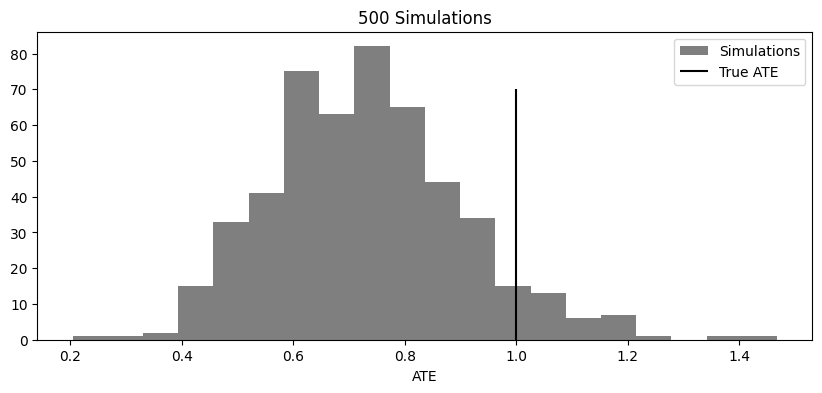

In [141]:
np.random.seed(123)

def sim_s_learner_ate():
    n = 10000                                       # number of samples
    nx = 20                                         # number of features

    X = np.random.normal(0, 1, (n,nx))              # feature set
    coefs_y = np.random.uniform(-1, 1, nx)          # coefficients for features
    coefs_t = np.random.uniform(-0.5, 0.5, nx)      # coefficient for treatment 

    ps = 1 / (1 + np.exp(-(X.dot(coefs_t))))        # logistic regression, probability of class 1, ps
    t = np.random.binomial(1, ps)                   # discrete treatment, binomial of probability equal ps
    te = 1                                          # treatment effect

    y = np.random.normal(t*te + X.dot(coefs_y), 1)  # actual outcome from normal dist of expected outcome

    s_learner = LGBMRegressor(max_depth=5, n_jobs=-1)
    s_learner.fit(np.concatenate([X, t.reshape(-1,1)], axis=1),y) # reshape treatment and add to features

    ate_hat = (s_learner.predict(np.concatenate([X, np.ones((n,1))], axis=1)) # s learner for discrete treatment
               - s_learner.predict(np.concatenate([X, np.zeros((n,1))], axis=1))).mean() # ate calculation
    
    return ate_hat 

ates = [sim_s_learner_ate() for _ in range(500)]

plt.figure(figsize=(10,4))
plt.hist(ates, alpha=0.5, bins=20, label="Simulations")
plt.vlines(1, 0, 70, label="True ATE")
plt.legend()
plt.xlabel("ATE")
plt.title("500 Simulations")   # under estimates treatment effect

#### Double / Debiased Machine Learning 

Double / Debiased ML or R-learner can be seen as a buffed version of the Frisch-Waugh-Lovell theorem. The idea is to use ML models when constructing outcome and treatment residuals:

$Y_i - \hat \mu _y (X_i) = \tau ﹒(T_i - \hat \mu _t (X_i)) + \epsilon _i$

where $\hat \mu _y (X_i)$ is estimating $E[Y|X]$ and $\hat \mu _t (X_i)$ is estimating $E[T|X]$

The flexibility of ML models allows to capture interactions and nonlinearities when estimating Y and T residuals while maintaining FWL-style orthogonalization. This means you don't have to make any parametric assumption about the relationship between the covariates X and the outcome Y nor between the covariates and the treatment in order to get the correct treatment effect. Provided you don't have unobserved confounders, you can recover the ATE with the following orthogonalization procedure:

1. Estimate the outcome Y with features X using a flexible ML regression model $\mu _y$.
2. Estimate the treatment with features X using a flexible ML regression model $\mu _t$.
3. Obtain the residuals $\tilde Y = Y - \mu _y(X)$ and $\tilde T = T - \mu _t(X)$  

The issue with ML model is obviously overfitting. If $\mu _y$ is overfitting, the residual $\tilde Y$ will be smaller than it should be. This also means that $\mu _y$ is capturing more than only the relationship between X and Y. Specifically $\mu _y$ is also capturing the relationship between T and Y, and if that is the case, the residual regression will be biased toward zero, since $\mu _y$ is capturing the causal relationship and not leaving it to the final residual regression.

If $\mu _t$ is overfitting, it will explain more of the variance in T than it should. As a result, the treatment residual will have less variance than it should. If there is less variance in the treatment, the variance of the final estimator will be high. It is as if the treatment is the same for almost everyone, or if the positivity assumption was violated. If everyone has almost the same treatment level, it becomes very difficult to estimate what would happen under different treatment.

To manage overfitting when using ML models, we can use cross predictions and out-of-fold residuals. Instead of getting the residuals in the same data used to fit the model, you'll partition you data into K folds, estimating the model in K-1 of those folds and getting the residuals in the fold that was left out. Repeat the same procedure K times to get the residuals for the entire dataset. With this procedure, even if the model does overfit, it won't drive residuals to zero artificially.

You can use the cross_val_predict function in sklearn to get out-of-fold predictions from any machine learning model. Once you have the residuals, you can regress the residual of the outcome on the residual of the treatment to get the ATE if that's what you're after. But how do you get the CATE.

In [148]:
from sklearn.model_selection import cross_val_predict 

X = ["month", "weekday", "is_holiday", "competitors_price"]
T = "discounts"
y = "sales"

debias_m = LGBMRegressor()              # for modeling T, treatement as a function of covariates X
denoise_m = LGBMRegressor()             # for modeling Y, outcome as a function of covariates X

t_res = train[T] - cross_val_predict(debias_m, train[X], train[T], cv=5)  # cross-validation treatment residuals
y_res = train[y] - cross_val_predict(denoise_m, train[X], train[y], cv=5) # cross-validation outcome residuals

In [149]:
# ATE estimation
import statsmodels.api as sm 

sm.OLS(y_res, t_res).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
discounts,31.4615,0.151,208.990,0.000,31.166,31.757


#### Double-ML for CATE estimation

To get CATE predictions from Double-ML model (instead of ATE), you need to allow causal parameter $\tau$ to change depending on unit's covariates:

$Y_i = \hat \mu_y(X_i)+\tau(X_i)(T_i-\hat \mu_t(X))+\hat \epsilon_i$

where $\hat \mu_y$ and $\hat \mu_t$ are models that predict the outcome and treatment from the features X. Isolating the error yields:

$\hat \epsilon_i = (Y_i - \hat \mu_y(X_i))-\tau(X_i)(T_i-\hat\mu_t(X))$

This is effectively a causal loss function, which means that, if you minimize the square of this loss, you'll be estimating the expected value of $\tau(X_i)$, which is the CATE:

$\hat L_n(\tau(x))=\frac{1}{n}\Sigma^n_{i=1}((Y_i-\hat M_y(X_i)) -\tau(X_i)(T_i-\hat M_t(X)))^2$

This is called the R-Loss, since its what the R-learner minimizes. Now rewriting the loss function in terms of the residualized version of treatment and outcome:

$\hat L_n(\tau(x))=\frac{1}{n}\Sigma^n_{i=1}(\tilde Y_i - \tau(X_i)(\tilde T_i))^2$

$\hat L_n(\tau(x))=\frac{1}{n}\Sigma^n_{i=1}\tilde T_i ^2(\frac{\tilde Y_i}{\tilde T_i} - \tau(X_i))^2$

Minimizing the preceding loss is equivalent to minimizing what is inside the parentheses, but weighting each term by $\tilde T_i^2$, which any predictive ML model can do. This is the transformed target used to compute mean square error for regression CATE models. This learner directly outputs CATE estimates, and does a decent job in terms of ordering the CATE, as measured by cumulative gain.

In [150]:
y_star = y_res/t_res    # transformed target that approximates treatment effect for each individual
w = t_res**2            # weight to correct for very small values of target  

cate_model = LGBMRegressor().fit(train[X], y_star, sample_weight=w)  # weighted model to predict target 
test_r_learner_pred = test.assign(cate = cate_model.predict(test[X]))

Text(0.5, 1.0, 'R-Learner')

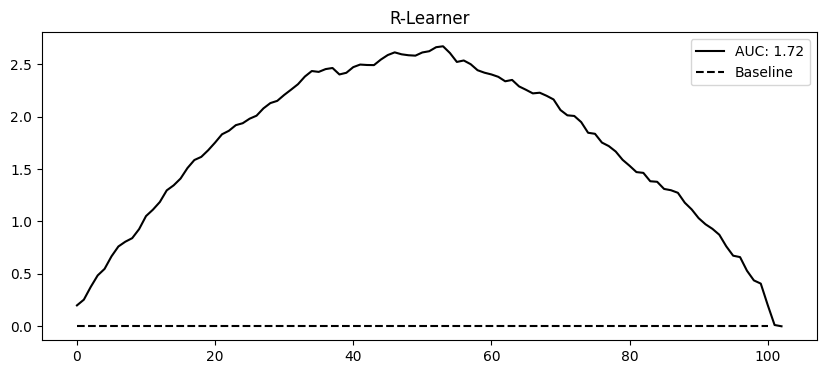

In [151]:
gain_curve_test = relative_cumulative_gain_curve(test_r_learner_pred, T, y, prediction="cate")
auc = area_under_the_relative_cumulative_gain_curve(test_r_learner_pred, T, y, prediction="cate")

plt.figure(figsize=(10,4))
plt.plot(gain_curve_test, color="C0", label=f"AUC: {auc:.2f}")
plt.hlines(0, 0, 100, linestyle='--', color="black", label=f"Baseline")

plt.legend()
plt.title("R-Learner")

#### Visual Intuition for Double-ML

In [152]:
np.random.seed(123)
n=5000                              # number of samples

x_h = np.random.randint(1,4,n)      # confounder
x_c = np.random.uniform(-1,1,n)     # drives heterogeneity

t = np.random.normal(10 + 1*x_c + 3*x_c**2 + x_c**3, 0.3)           # continuous treatment
y = np.random.normal(t + x_h*t - 5*x_c -x_c**2 - x_c**3, 0.3)       # outcome

df_sim = pd.DataFrame(dict(x_h=x_h, x_c=x_c, t=t, y=y))
df_sim.head()

,x_h,x_c,t,y
0,3,-0.764412,10.865583,47.599055
1,2,-0.003026,9.929159,29.740716
2,3,0.194219,9.768409,38.436420
3,3,-0.318490,9.875412,41.505370
4,1,0.422232,10.733710,19.116208


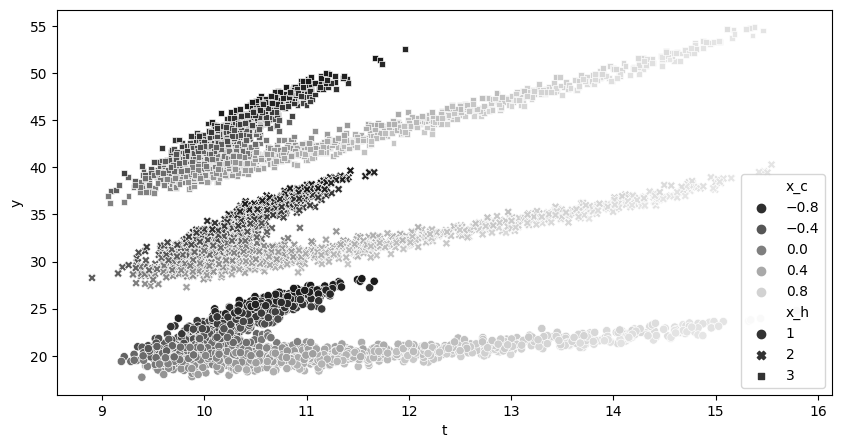

In [153]:
import matplotlib 

plt.figure(figsize=(10,5))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["0.1", "0.5", "0.9"])

sns.scatterplot(data=df_sim, y="y", x="t", hue="x_c", style="x_h", palette=cmap)
plt.legend()

In [159]:
debias_m = LGBMRegressor(max_depth=3)
denoise_m = LGBMRegressor(max_depth=3)

# predictions
t_res = cross_val_predict(debias_m, df_sim[["x_c"]], df_sim[["t"]], cv=10) # debiase using only confounder
y_res = cross_val_predict(denoise_m, df_sim[["x_c", "x_h"]], df_sim["y"], cv=10) # denoise using both covariates

# residuals
df_res = df_sim.assign(
    t_res = df_sim["t"] - t_res,    
    y_res = df_sim["y"] - y_res
)

In [160]:
import statsmodels.formula.api as smf 

smf.ols("y_res~t_res", data=df_res).fit().params["t_res"]   # ate

3.0452301460062996

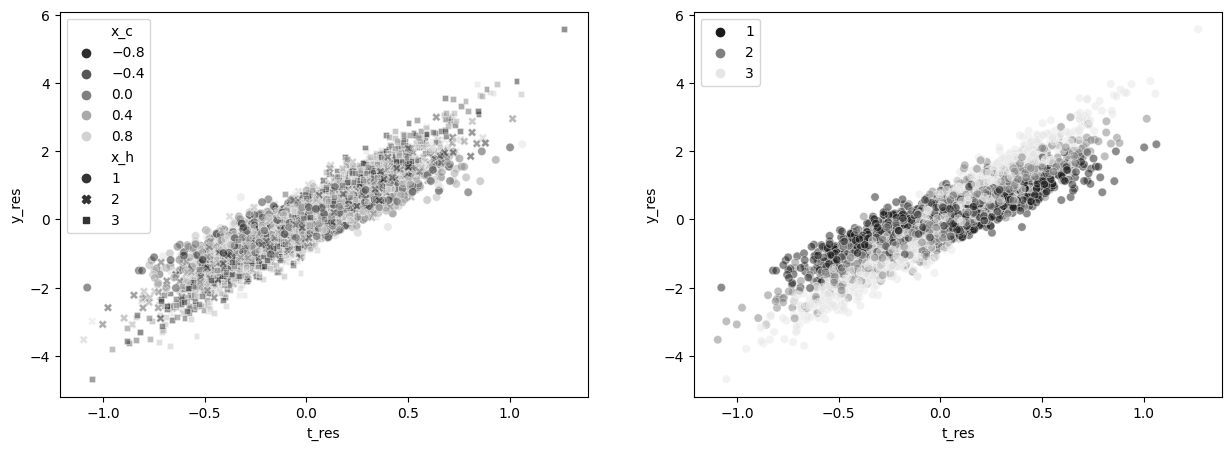

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1 = sns.scatterplot(data=df_res, y="y_res", x="t_res", hue="x_c",  # residuals by confounder
                      style="x_h", alpha=0.5, ax=ax1, palette=cmap)

h, l = ax1.get_legend_handles_labels()
ax1.legend()

sns.scatterplot(data=df_res, y="y_res", x="t_res", hue="x_h", ax=ax2, 
                alpha=0.5, palette=cmap)    # residuals by heterogeneity
ax2.legend()

In [164]:
df_star = df_res.assign(
    y_star = df_res["y_res"]/ df_res["t_res"],      # unweighted individual ate prediction
    weight = df_res["t_res"]**2                     # weights
)                                   

# for the unique values of the covariate driving heterogeneity
for x in range(1,4):
    cate = np.average(df_star.query(f"x_h=={x}")["y_star"],     # cate for heterogeneity covariate
                      weights=df_star.query(f"x_h=={x}")["weight"]) # weighted average of transformed target
    print(f"CATE x_h={x}", cate)


CATE x_h=1 2.019759619990067
CATE x_h=2 2.974967932350952
CATE x_h=3 3.9962382855476957


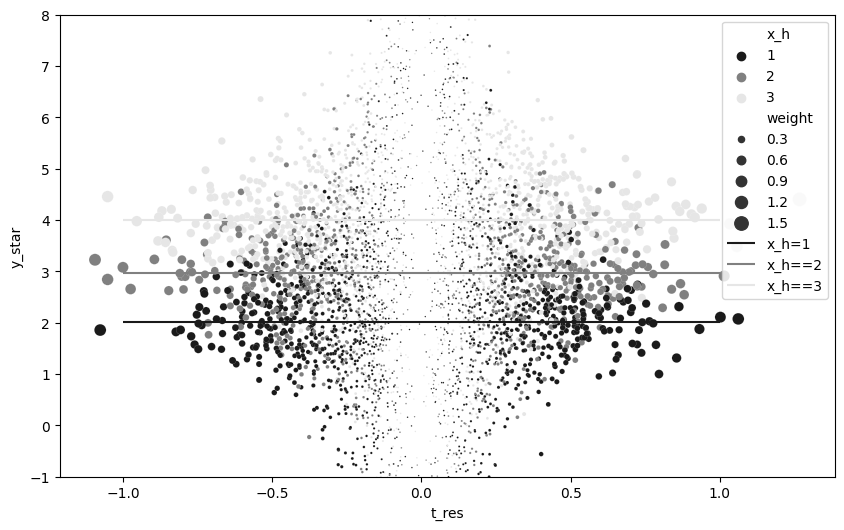

In [169]:
plt.figure(figsize=(10,6))

sns.scatterplot(data=df_star, palette=cmap,
                y='y_star', x='t_res', hue='x_h', size='weight', sizes=(1, 100))
plt.hlines(np.average(df_star.query("x_h==1")["y_star"], weights=df_star.query("x_h==1")["weight"]),
           -1, 1, label="x_h=1", color="0.1")
plt.hlines(np.average(df_star.query("x_h==2")["y_star"], weights=df_star.query("x_h==2")["weight"]),
           -1, 1, label="x_h==2", color="0.5")
plt.hlines(np.average(df_star.query("x_h==3")["y_star"], weights=df_star.query("x_h==3")["weight"]),
           -1, 1, label="x_h==3", color="0.9")
plt.ylim(-1,8)
plt.legend()
